In [1]:
import os

import nltk

from cltk.corpus.latin import latinlibrary

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
vectorizer = CountVectorizer(input='content')

In [3]:
# Get poetry

virgil_files = [file for file in latinlibrary.fileids() if 'vergil/a' in file]
len(latinlibrary.raw(virgil_files))

470509

In [4]:
# Get prose

cicero_files = [file for file in latinlibrary.fileids() if 'cicero/or' in file]
len(latinlibrary.raw(cicero_files))

561642

In [5]:
virgil_raws = []

for file in virgil_files:
    virgil_raws.append(latinlibrary.raw(file)[1000:-1000])

In [6]:
cicero_raws = []

for file in cicero_files:
    cicero_raws.append(latinlibrary.raw(file)[1000:-1000])

In [7]:
# Script for preprocessing texts

import html
import re
import string
from cltk.stem.latin.j_v import JVReplacer

def preprocess(text):
    
    replacer = JVReplacer()
    
#     remove_list = [r'\bThe Latin Library\b',
#                    r'\bThe Classics Page',
#                    r'\bVergil: Aeneid .+\b',
#                    r'\bP. VERGILI MARONIS AENEIDOS LIBER .+\b',
#                    r'\bVergil\b'
#                   ]
    
#     for pattern in remove_list:
#         text = re.sub(pattern, '', text)
    
    text = html.unescape(text) # Handle html entities
    text = re.sub(r'&nbsp;?', ' ',text) #&nbsp; stripped incorrectly in corpus?
    text = re.sub(r'\x00',' ',text) #Another space problem?
        
    text = text.lower()
    text = replacer.replace(text) #Normalize u/v & i/j    
    
    punctuation ="\"#$%&\'()*+,-/:;<=>@[\]^_`{|}~.?!«»—"
    translator = str.maketrans({key: " " for key in punctuation})
    text = text.translate(translator)
    
    translator = str.maketrans({key: " " for key in '0123456789'})
    text = text.translate(translator)
    
    text = re.sub('[ ]+',' ', text) # Remove double spaces
    text = re.sub('\s+\n+\s+','\n', text) # Remove double lines and trim spaces around new lines
    
    return text.strip()

In [8]:
virgil_pp = [preprocess(raw) for raw in virgil_raws]
cicero_pp = [preprocess(raw) for raw in cicero_raws]

In [9]:
texts = cicero_pp + virgil_pp
titles = cicero_files + virgil_files

In [10]:
dtm = vectorizer.fit_transform(texts)

In [11]:
vocab = np.array(vectorizer.get_feature_names())

In [12]:
dtm = dtm.toarray()

In [13]:
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)

In [14]:
rates[:, 100:105]

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.17686594, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.168492  , 0.168492  ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.23435669, 0.        , 0.23435669, 0.        , 0.23435669],
       [0.23223409, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.

In [15]:
vocab[100:105]

array(['abrumpit', 'abrumpunt', 'abruptis', 'abrupto', 'abruptum'],
      dtype='<U19')

In [16]:
cicero_indices, virgil_indices = [], []

for index, fn in enumerate(titles):
    if "cic" in fn:
        cicero_indices.append(index)
    elif "verg" in fn:
        virgil_indices.append(index)

In [17]:
ensis_cicero = np.sum(dtm[cicero_indices, vocab=='ensis'])
non_ensis_cicero = np.sum(dtm[cicero_indices, :]) - ensis_cicero
ensis_virgil = np.sum(dtm[virgil_indices, vocab=='ensis'])
non_ensis_virgil = np.sum(dtm[virgil_indices, :]) - ensis_virgil

In [18]:
ensis_table = np.array([[ensis_cicero, non_ensis_cicero], 
                        [ensis_virgil, non_ensis_virgil]])

In [19]:
ensis_table

array([[    0, 79756],
       [    9, 60536]], dtype=int64)

In [20]:
labels = []

for fn in titles:
    label = "cicero" if "cic" in fn else "virgil"
    labels.append(label)

In [21]:
from sklearn.preprocessing import LabelBinarizer

X = dtm[:, vocab == "arma"]

X = np.append(X, np.sum(dtm[:, vocab != "arma"], axis=1, keepdims=True), axis=1)

y = LabelBinarizer().fit_transform(labels)

y = np.append(1 - y, y, axis=1)

green_table = np.dot(y.T, X)

green_table

array([[    5, 79751],
       [  138, 60407]], dtype=int64)

In [22]:
feature_count = np.sum(X, axis=0, keepdims=True)
class_prob = np.mean(y, axis=0, keepdims=True)
expected_table = np.dot(class_prob.T, feature_count)
expected_table

array([[3.575000e+01, 3.503950e+04],
       [1.072500e+02, 1.051185e+05]])

In [23]:
G = np.sum(green_table * np.log(green_table / expected_table))

In [24]:
G

32150.36108492303

In [25]:
from sklearn.feature_selection import chi2
keyness, _ = chi2(dtm, labels)

In [26]:
ranking = np.argsort(keyness)[::-1]

In [27]:
ranking[0:10]

array([12367, 27795,  8711, 16999, 21249,  8716,  2901,  8704, 23047,
        6249])

In [28]:
vocab[ranking][0:10]

array(['in', 'ut', 'est', 'non', 'quod', 'et', 'aut', 'esse', 'sed', 'de'],
      dtype='<U19')

In [29]:
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

dist = 1 - cosine_similarity(dtm)

mds = MDS(n_components=2, dissimilarity="precomputed")

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

Text(0.5,1,'Before feature selection')

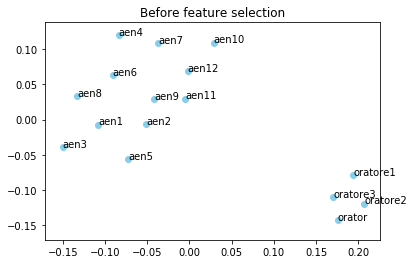

In [30]:
xs, ys = pos[:, 0], pos[:, 1]

names = [os.path.basename(fn).replace('.txt', '') for fn in titles]

for x, y, name in zip(xs, ys, names):
    color = 'orange' if "cic" in name else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)

plt.title("Before feature selection")

Text(0.5,1,'After feature selection')

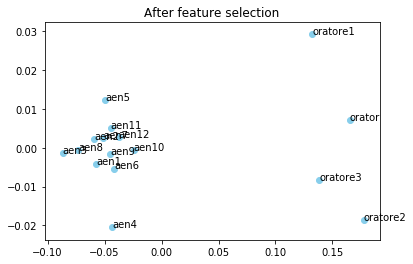

In [31]:
keyness, _ = chi2(dtm, names)

selected = np.argsort(keyness)[::-1][0:50]

dtm_chi2 = dtm[:, selected]

dist = 1 - cosine_similarity(dtm_chi2)

mds = MDS(n_components=2, dissimilarity="precomputed")

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

for x, y, name in zip(xs, ys, names):
    color = 'orange' if "cic" in name else 'skyblue'
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)

plt.title("After feature selection")

In [32]:
selected

array([12367, 27795,  8711, 16999, 21249,  8716,  8704,  2901, 23047,
        6249,  5963,  8472, 21169, 23447, 21003,  8721, 24712, 21083,
         482, 21183, 23674, 13097,  8841,  2902, 11594, 11883, 21186,
       25022,  2520, 16848, 16769, 26592, 21386,  3609, 21244, 10915,
       13788,  8102, 13974, 12034,   172,  7060, 16124, 16543, 22608,
       21121, 26779, 17822,  8709, 12019])

In [33]:
vocab[12367]

'in'

In [34]:
for item in selected:
    print(vocab[item])

in
ut
est
non
quod
et
esse
aut
sed
de
cum
enim
qui
si
quae
etiam
sunt
quam
ad
quid
sit
inquit
ex
autem
hoc
id
quidem
tamen
atque
nihil
neque
uel
re
causa
quo
genere
ita
ea
iuris
illud
ac
dicendi
modo
nam
saepe
quasi
uerborum
orationis
esset
illa


In [35]:
pos.shape

(16, 2)

In [36]:
import pandas as pd

In [37]:
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)

In [38]:
df = pd.DataFrame(rates, columns=vocab, index=titles)
df.iloc[:,:5]

,ab,abactae,abacti,abalienantque,abalienati
cicero/orator.txt,3.222987,0.000000,0.000000,0.000000,0.000000
cicero/oratore1.txt,3.266888,0.000000,0.000000,0.000000,0.000000
cicero/oratore2.txt,2.051550,0.000000,0.000000,0.037301,0.037301
cicero/oratore3.txt,3.256740,0.000000,0.000000,0.000000,0.000000
vergil/aen1.txt,2.608696,0.000000,0.000000,0.000000,0.000000
vergil/aen10.txt,1.772421,0.000000,0.000000,0.000000,0.000000
vergil/aen11.txt,2.299257,0.000000,0.176866,0.000000,0.000000
vergil/aen12.txt,1.516428,0.000000,0.000000,0.000000,0.000000
vergil/aen2.txt,1.222245,0.000000,0.000000,0.000000,0.000000
vergil/aen3.txt,2.343567,0.000000,0.000000,0.000000,0.000000


In [39]:
df.iloc[:,selected]

,in,ut,est,non,quod,et,esse,aut,sed,de,...,ac,dicendi,modo,nam,saepe,quasi,uerborum,orationis,esset,illa
cicero/orator.txt,26.330165,15.677920,18.846280,15.623293,10.925380,32.065989,5.462690,12.400306,12.017918,7.101497,...,1.857315,1.584180,3.605375,3.441495,2.676718,3.113733,3.113733,2.895226,1.693434,2.458210
cicero/oratore1.txt,27.187154,10.299003,9.800664,13.898117,9.966777,30.232558,10.520487,9.302326,7.641196,10.741971,...,5.094131,3.211517,2.270210,2.270210,1.328904,1.052049,0.775194,0.609081,3.045404,2.380952
cicero/oratore2.txt,24.618598,16.971912,16.561602,16.524302,10.630758,28.162184,8.430005,11.451378,9.138722,7.758589,...,3.468984,2.051550,2.238054,2.722966,2.648364,1.380134,1.007124,1.566638,1.790444,3.058674
cicero/oratore3.txt,22.917797,17.067728,15.620288,14.775948,9.408359,32.024606,7.478439,12.242929,8.865569,6.694409,...,4.704179,2.171160,2.533020,3.075810,1.568060,2.774260,2.593330,2.050540,0.844340,3.015500
vergil/aen1.txt,10.434783,2.173913,3.260870,3.478261,0.869565,34.130435,0.217391,5.217391,2.173913,0.869565,...,2.391304,0.000000,0.434783,0.869565,0.434783,0.000000,0.000000,0.000000,0.000000,0.652174
vergil/aen10.txt,12.052464,2.835874,4.253811,4.785537,0.886211,28.358738,0.886211,4.608295,3.190358,2.304147,...,0.886211,0.000000,0.000000,0.708968,0.354484,0.000000,0.000000,0.000000,0.000000,1.595179
vergil/aen11.txt,14.856739,3.183587,3.006721,4.775380,0.884330,34.842589,0.530598,2.829855,2.652989,1.945525,...,1.238062,0.000000,0.176866,0.353732,0.000000,0.000000,0.000000,0.000000,0.176866,1.414927
vergil/aen12.txt,13.984836,4.212300,3.538332,5.054760,1.010952,32.350463,0.000000,4.549284,0.842460,1.179444,...,2.021904,0.000000,0.000000,0.336984,0.336984,0.000000,0.000000,0.000000,0.000000,0.336984
vergil/aen2.txt,14.259523,2.037075,2.240782,4.277857,1.629660,38.908128,0.000000,4.074150,1.018537,1.425952,...,1.629660,0.000000,0.203707,0.814830,0.407415,0.000000,0.000000,0.000000,0.203707,1.018537
vergil/aen3.txt,9.374268,0.703070,3.984064,1.406140,0.468713,41.949848,0.000000,2.343567,2.577924,2.343567,...,1.406140,0.000000,0.468713,1.874854,0.468713,0.000000,0.000000,0.000000,0.000000,1.171783


In [40]:
df.loc[:,['uxor','coniunx']]

,uxor,coniunx
cicero/orator.txt,0.054627,0.000000
cicero/oratore1.txt,0.000000,0.000000
cicero/oratore2.txt,0.037301,0.000000
cicero/oratore3.txt,0.000000,0.000000
vergil/aen1.txt,0.000000,0.434783
vergil/aen10.txt,0.000000,0.531726
vergil/aen11.txt,0.000000,0.353732
vergil/aen12.txt,0.000000,0.673968
vergil/aen2.txt,0.000000,1.629660
vergil/aen3.txt,0.000000,0.000000


In [41]:
prose_index = [t for t in titles if 'cic' in t]
verse_index = [t for t in titles if 'ver' in t]

In [42]:
p_sum = df.loc[prose_index].sum().tolist()
v_sum = df.loc[verse_index].sum().tolist()

In [43]:
df2 = pd.DataFrame(list(zip(p_sum, v_sum)), columns = ['prose', 'verse'], index=vocab)

In [44]:
df2['poeticness'] = df2['verse'] / (df2['prose'] + df2['verse'])

In [45]:
df2.loc['coniunx']

prose         0.000000
verse         7.104869
poeticness    1.000000
Name: coniunx, dtype: float64

In [46]:
df2.loc['uxor']

prose         0.091928
verse         0.000000
poeticness    0.000000
Name: uxor, dtype: float64

In [47]:
df2.loc['amor']

prose         0.037301
verse         5.183147
poeticness    0.992855
Name: amor, dtype: float64

In [48]:
df2.loc['in']

prose         101.053715
verse         142.854317
poeticness      0.585689
Name: in, dtype: float64

In [49]:
df2.loc['eis']

prose         7.068492
verse         0.000000
poeticness    0.000000
Name: eis, dtype: float64

In [50]:
ode = preprocess("""Ne forte credas interitura quae
longe sonantem natus ad Aufidum
non ante volgatas per artis
verba loquor socianda chordis:
non, si priores Maeonius tenet
sedes Homerus, Pindaricae latent
Ceaeque et Alcaei minaces
Stesichorique graves Camenae

nec siquid olim lusit Anacreon
delevit aetas; spirat adhuc amor
vivuntque conmissi calores
Aeoliae fidibus puellae.

non sola comptos arsit adulteri
crinis et aurum vestibus inlitum
mirata regalisque cultus
et comites Helene Lacaena

primusve Teucer tela Cydonio
direxit arcu; non semel Ilios
vexata; non pugnavit ingens
Idomeneus Sthenelusve solus

dicenda Musis proelia; non ferox
Hector vel acer Deiphobus gravis
excepit ictus pro pudicis
coniugibus puerisque primus.

vixere fortes ante Agamemnona
multi; sed omnes inlacrimabiles
urgentur ignotique longa
nocte, carent quia vate sacro.

paullum sepultae distat inertiae
celata virtus. non ego te meis
chartis inornatum silebo,
totve tuos patiar labores

inpune, Lolli, carpere lividas
obliviones. est animus tibi
rerumque prudens et secundis
temporibus dubiisque rectus,

vindex avarae fraudis et abstinens
ducentis ad se cuncta pecuniae,
consulque non unius anni,
sed quotiens bonus atque fidus
iudex honestum praetulit utili,
reiecit alto dona nocentium
voltu, per obstantis catervas
explicuit sua victor arma.

non possidentem multa vocaveris
recte beatum; rectius occupat
nomen beati qui deorum
muneribus sapienter uti

duramque callet pauperiem pati
peiusque leto flagitium timet,
non ille pro caris amicis
aut patria timidus perire.""")

In [51]:
ode_tokens = ode.split()

In [52]:
print(ode_tokens)

['ne', 'forte', 'credas', 'interitura', 'quae', 'longe', 'sonantem', 'natus', 'ad', 'aufidum', 'non', 'ante', 'uolgatas', 'per', 'artis', 'uerba', 'loquor', 'socianda', 'chordis', 'non', 'si', 'priores', 'maeonius', 'tenet', 'sedes', 'homerus', 'pindaricae', 'latent', 'ceaeque', 'et', 'alcaei', 'minaces', 'stesichorique', 'graues', 'camenae', 'nec', 'siquid', 'olim', 'lusit', 'anacreon', 'deleuit', 'aetas', 'spirat', 'adhuc', 'amor', 'uiuuntque', 'conmissi', 'calores', 'aeoliae', 'fidibus', 'puellae', 'non', 'sola', 'comptos', 'arsit', 'adulteri', 'crinis', 'et', 'aurum', 'uestibus', 'inlitum', 'mirata', 'regalisque', 'cultus', 'et', 'comites', 'helene', 'lacaena', 'primusue', 'teucer', 'tela', 'cydonio', 'direxit', 'arcu', 'non', 'semel', 'ilios', 'uexata', 'non', 'pugnauit', 'ingens', 'idomeneus', 'sthenelusue', 'solus', 'dicenda', 'musis', 'proelia', 'non', 'ferox', 'hector', 'uel', 'acer', 'deiphobus', 'grauis', 'excepit', 'ictus', 'pro', 'pudicis', 'coniugibus', 'puerisque', 'prim

In [53]:
ode_score = []

for token in ode_tokens:
    if token in vocab:
        ode_score.append(df2.loc[token][2]-.5)
    else:
        ode_score.append(0)
print(ode_score)        

[0.060246391536661115, 0.3860016497312063, 0.5, 0, 0.07457464963121052, 0.36305609862563204, 0.5, -0.28033845353766024, 0.1572591747473162, 0, -0.03437729138429463, 0.3157758870641656, 0, 0.46400107348355735, -0.09428544211822476, -0.14125286487904726, -0.12002916683740694, 0, 0, -0.03437729138429463, 0.04780340597055366, 0.3840576731324684, 0, 0.4473362511466066, 0.4566383365289819, 0, 0, 0, 0, 0.27019702072427587, 0, 0, 0, -0.5, 0, 0.3599972455173628, 0, 0.3746992711565533, 0.26573058493033286, 0, 0, 0.2518151179736774, 0, 0.2924768666167098, 0.492854845673242, 0, 0, 0, 0, -0.5, 0.5, -0.03437729138429463, 0.4426930401692919, 0.5, 0.5, 0, 0.5, 0.27019702072427587, 0.3845267099735876, 0, 0, 0.5, 0.5, 0.5, 0.27019702072427587, 0.4783299232284647, 0, 0, 0, 0, 0.4834375981941016, 0, 0, 0.5, -0.03437729138429463, 0.28590345014577456, 0, 0, -0.03437729138429463, -0.5, 0.5, 0.5, 0, 0.400825323954749, -0.5, 0.28492410599434015, 0.4871717096883943, -0.03437729138429463, 0.5, 0.5, -0.2478684316

In [54]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [55]:
ode_score_running = running_mean(ode_score, 10)

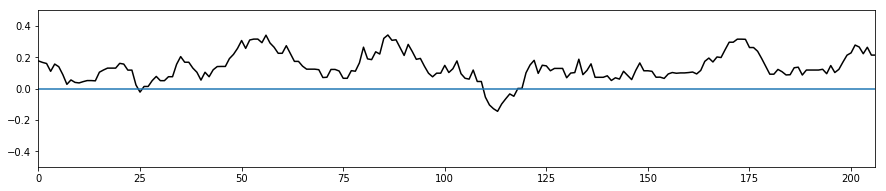

In [71]:
#window = 25
#bc5_smooth = smooth_list(y,window)

fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(ode_score_running, color="k")

#t =  plt.title('Smoothed Distribution of Tesserae Matches for Elegists ~ Lucan Book 5',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)
ax.set_xlim(0,len(ode_score_running)-1)

#ax.set_xlabel('Line Number', fontsize = 14)
#ax.set_ylabel('Count of Matches >=6', fontsize = 14)
plt.show()

In [57]:
print(" ".join(ode_tokens[100:125]))

primus uixere fortes ante agamemnona multi sed omnes inlacrimabiles urgentur ignotique longa nocte carent quia uate sacro paullum sepultae distat inertiae celata uirtus non ego


In [58]:
amicitia = preprocess('Q. Mucius augur multa narrare de C. Laelio socero suo memoriter et iucunde solebat nec dubitare illum in omni sermone appellare sapientem. ego autem a patre ita eram deductus ad Scaevolam sumpta virili toga, ut, quoad possem et liceret, a senis latere numquam discederem. itaque multa ab eo prudenter disputata, multa etiam breviter et commode dicta memoriae mandabam, fierique studebam eius prudentia doctior. quo mortuo me ad pontificem Scaevolam contuli, quem unum nostrae civitatis et ingenio et iustitia praestantissimum audeo dicere. sed de hoc alias, nunc redeo ad augurem.')
am_tokens = amicitia.split()

In [59]:
am_score = []

for token in am_tokens:
    if token in vocab:
        am_score.append(df2.loc[token][2]-.5)
    else:
        am_score.append(0)
        
am_score_running = running_mean(am_score, 10)

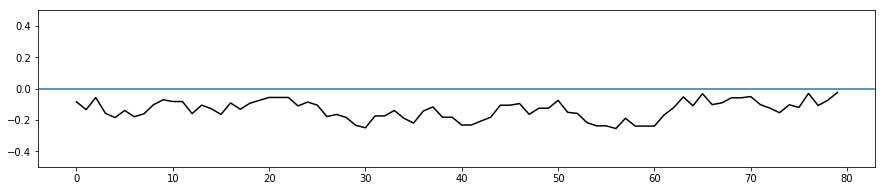

In [60]:
#window = 25
#bc5_smooth = smooth_list(y,window)

fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(am_score_running, color="k")

#t =  plt.title('Smoothed Distribution of Tesserae Matches for Elegists ~ Lucan Book 5',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)

#ax.set_xlabel('Line Number', fontsize = 14)
#ax.set_ylabel('Count of Matches >=6', fontsize = 14)
plt.show()

In [61]:
met = preprocess("""Aurea prima sata est aetas, quae vindice nullo,
90sponte sua, sine lege fidem rectumque colebat.
Poena metusque aberant, nec verba minantia fixo
aere legebantur, nec supplex turba timebat
iudicis ora sui, sed erant sine vindice tuti.
Nondum caesa suis, peregrinum ut viseret orbem,
95montibus in liquidas pinus descenderat undas,
nullaque mortales praeter sua litora norant.
Nondum praecipites cingebant oppida fossae;
non tuba directi, non aeris cornua flexi,
non galeae, non ensis erat: sine militis usu
100mollia securae peragebant otia gentes.
ipsa quoque inmunis rastroque intacta nec ullis
saucia vomeribus per se dabat omnia tellus;
contentique cibis nullo cogente creatis
arbuteos fetus montanaque fraga legebant
105cornaque et in duris haerentia mora rubetis
et quae deciderant patula Iovis arbore glandes.
Ver erat aeternum, placidique tepentibus auris
mulcebant zephyri natos sine semine flores.
Mox etiam fruges tellus inarata ferebat,
110nec renovatus ager gravidis canebat aristis;
flumina iam lactis, iam flumina nectaris ibant,
flavaque de viridi stillabant ilice mella.
Postquam, Saturno tenebrosa in Tartara misso,
sub Iove mundus erat, subiit argentea proles,
115auro deterior, fulvo pretiosior aere.
Iuppiter antiqui contraxit tempora veris
perque hiemes aestusque et inaequalis autumnos
et breve ver spatiis exegit quattuor annum.
Tum primum siccis aer fervoribus ustus
120canduit, et ventis glacies adstricta pependit.
Tum primum subiere domus (domus antra fuerunt
et densi frutices et vinctae cortice virgae).
Semina tum primum longis Cerealia sulcis
obruta sunt, pressique iugo gemuere iuvenci.
125Tertia post illam successit aenea proles,
saevior ingeniis et ad horrida promptior arma,
non scelerata tamen. De duro est ultima ferro.
Protinus inrupit venae peioris in aevum
omne nefas: fugere pudor verumque fidesque;
130In quorum subiere locum fraudesque dolique
insidiaeque et vis et amor sceleratus habendi.
Vela dabat ventis (nec adhuc bene noverat illos)
navita; quaeque diu steterant in montibus altis,
fluctibus ignotis insultavere carinae,
135communemque prius ceu lumina solis et auras
cautus humum longo signavit limite mensor.
Nec tantum segetes alimentaque debita dives
poscebatur humus, sed itum est in viscera terrae:
quasque recondiderat Stygiisque admoverat umbris,
140effodiuntur opes, inritamenta malorum.
Iamque nocens ferrum ferroque nocentius aurum
prodierat: prodit bellum, quod pugnat utroque,
sanguineaque manu crepitantia concutit arma.
Vivitur ex rapto: non hospes ab hospite tutus,
145non socer a genero; fratrum quoque gratia rara est.
Inminet exitio vir coniugis, illa mariti;
lurida terribiles miscent aconita novercae;
filius ante diem patrios inquirit in annos.
Victa iacet pietas, et virgo caede madentis,
150ultima caelestum terras Astraea reliquit.
""")
met_tokens = met.split()

In [62]:
met_score = []

for token in met_tokens:
    if token in vocab:
        met_score.append(df2.loc[token][2]-.5)
    else:
        met_score.append(0)
        
met_score_running = running_mean(met_score, 10)

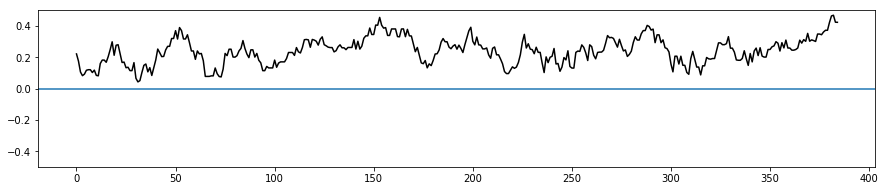

In [63]:
#window = 25
#bc5_smooth = smooth_list(y,window)

fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(met_score_running, color="k")

#t =  plt.title('Smoothed Distribution of Tesserae Matches for Elegists ~ Lucan Book 5',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)

#ax.set_xlabel('Line Number', fontsize = 14)
#ax.set_ylabel('Count of Matches >=6', fontsize = 14)
plt.show()

In [64]:
lucan = preprocess("""Bella per Emathios plus quam ciuilia campos
iusque datum sceleri canimus, populumque potentem
in sua uictrici conuersum uiscera dextra
cognatasque acies, et rupto foedere regni
certatum totis concussi uiribus orbis                  5
in commune nefas, infestisque obuia signis
signa, pares aquilas et pila minantia pilis.
      quis furor, o ciues, quae tanta licentia ferri?
gentibus inuisis Latium praebere cruorem
cumque superba foret Babylon spolianda tropaeis                  10
Ausoniis umbraque erraret Crassus inulta
bella geri placuit nullos habitura triumphos?
heu, quantum terrae potuit pelagique parari
hoc quem ciuiles hauserunt sanguine dextrae,
unde uenit Titan et nox ubi sidera condit                  15
quaque dies medius flagrantibus aestuat horis
et qua bruma rigens ac nescia uere remitti
astringit Scythico glacialem frigore pontum!
sub iuga iam Seres, iam barbarus isset Araxes
et gens siqua iacet nascenti conscia Nilo.                  20
tum, si tantus amor belli tibi, Roma, nefandi,
totum sub Latias leges cum miseris orbem,
in te uerte manus: nondum tibi defuit hostis.
at nunc semirutis pendent quod moenia tectis
urbibus Italiae lapsisque ingentia muris                  25
saxa iacent nulloque domus custode tenentur
rarus et antiquis habitator in urbibus errat,
horrida quod dumis multosque inarata per annos
Hesperia est desuntque manus poscentibus aruis,
non tu, Pyrrhe ferox, nec tantis cladibus auctor                  30
Poenus erit: nulli penitus descendere ferro
contigit; alta sedent ciuilis uolnera dextrae.
      quod si non aliam uenturo fata Neroni
inuenere uiam magnoque aeterna parantur
regna deis caelumque suo seruire Tonanti                  35
non nisi saeuorum potuit post bella gigantum,
iam nihil, o superi, querimur; scelera ipsa nefasque
hac mercede placent. diros Pharsalia campos
inpleat et Poeni saturentur sanguine manes,
ultima funesta concurrant proelia Munda,                  40
his, Caesar, Perusina fames Mutinaeque labores
accedant fatis et quas premit aspera classes
Leucas et ardenti seruilia bella sub Aetna,
multum Roma tamen debet ciuilibus armis
quod tibi res acta est. te, cum statione peracta                  45
astra petes serus, praelati regia caeli
excipiet gaudente polo: seu sceptra tenere
seu te flammigeros Phoebi conscendere currus
telluremque nihil mutato sole timentem
igne uago lustrare iuuet, tibi numine ab omni                  50
cedetur, iurisque tui natura relinquet
quis deus esse uelis, ubi regnum ponere mundi.
sed neque in Arctoo sedem tibi legeris orbe
nec polus auersi calidus qua uergitur Austri,
unde tuam uideas obliquo sidere Romam.                  55
aetheris inmensi partem si presseris unam,
sentiet axis onus. librati pondera caeli
orbe tene medio; pars aetheris illa sereni
tota uacet nullaeque obstent a Caesare nubes.
tum genus humanum positis sibi consulat armis                  60
inque uicem gens omnis amet; pax missa per orbem
ferrea belligeri conpescat limina Iani.
sed mihi iam numen; nec, si te pectore uates
accipio, Cirrhaea uelim secreta mouentem
sollicitare deum Bacchumque auertere Nysa:                  65
tu satis ad uires Romana in carmina dandas.
      fert animus causas tantarum expromere rerum,
inmensumque aperitur opus, quid in arma furentem
inpulerit populum, quid pacem excusserit orbi.
inuida fatorum series summisque negatum                  70
stare diu nimioque graues sub pondere lapsus
nec se Roma ferens. sic, cum conpage soluta
saecula tot mundi suprema coegerit hora
antiquum repetens iterum chaos, [omnia mixtis
sidera sideribus concurrent,] ignea pontum                   75
astra petent, tellus extendere litora nolet
excutietque fretum, fratri contraria Phoebe
ibit et obliquum bigas agitare per orbem
indignata diem poscet sibi, totaque discors
machina diuolsi turbabit foedera mundi.                  80
in se magna ruunt: laetis hunc numina rebus
crescendi posuere modum. nec gentibus ullis
commodat in populum terrae pelagique potentem
inuidiam Fortuna suam. tu causa malorum
facta tribus dominis communis, Roma, nec umquam                  85
in turbam missi feralia foedera regni.
o male concordes nimiaque cupidine caeci,
quid miscere iuuat uires orbemque tenere
in medio? dum terra fretum terramque leuabit
aer et longi uoluent Titana labores                  90
noxque diem caelo totidem per signa sequetur,
nulla fides regni sociis, omnisque potestas
inpatiens consortis erit. nec gentibus ullis
credite nec longe fatorum exempla petantur:
fraterno primi maduerunt sanguine muri.                  95
nec pretium tanti tellus pontusque furoris
tunc erat: exiguum dominos commisit asylum.
      temporis angusti mansit concordia discors
paxque fuit non sponte ducum; nam sola futuri
Crassus erat belli medius mora. qualiter undas                  100
qui secat et geminum gracilis mare separat Isthmos
nec patitur conferre fretum, si terra recedat,
Ionium Aegaeo frangat mare, sic, ubi saeua
arma ducum dirimens miserando funere Crassus
Assyrias Latio maculauit sanguine Carrhas,                  105
Parthica Romanos soluerunt damna furores.
plus illa uobis acie, quam creditis, actum est,
Arsacidae: bellum uictis ciuile dedistis.
diuiditur ferro regnum, populique potentis,
quae mare, quae terras, quae totum possidet orbem,                  110
non cepit fortuna duos. nam pignora iuncti
sanguinis et diro ferales omine taedas
abstulit ad manes Parcarum Iulia saeua
intercepta manu. quod si tibi fata dedissent
maiores in luce moras, tu sola furentem                  115
inde uirum poteras atque hinc retinere parentem
armatasque manus excusso iungere ferro,
ut generos soceris mediae iunxere Sabinae.
morte tua discussa fides bellumque mouere
permissum ducibus. stimulos dedit aemula uirtus.                  120
tu, noua ne ueteres obscurent acta triumphos
et uictis cedat piratica laurea Gallis,
Magne, times; te iam series ususque laborum
erigit inpatiensque loci fortuna secundi;
nec quemquam iam ferre potest Caesarue priorem                  125
Pompeiusue parem. quis iustius induit arma
scire nefas: magno se iudice quisque tuetur;
uictrix causa deis placuit sed uicta Catoni.
nec coiere pares. alter uergentibus annis
in senium longoque togae tranquillior usu                  130
dedidicit iam pace ducem, famaeque petitor
multa dare in uolgus, totus popularibus auris
inpelli plausuque sui gaudere theatri,
nec reparare nouas uires, multumque priori
credere fortunae. stat magni nominis umbra,                  135
qualis frugifero quercus sublimis in agro
exuuias ueteris populi sacrataque gestans
dona ducum nec iam ualidis radicibus haerens
pondere fixa suo est, nudosque per aera ramos
effundens trunco, non frondibus, efficit umbram,                  140
et quamuis primo nutet casura sub Euro,
tot circum siluae firmo se robore tollant,
sola tamen colitur. sed non in Caesare tantum
nomen erat nec fama ducis, sed nescia uirtus
stare loco, solusque pudor non uincere bello.                  145
acer et indomitus, quo spes quoque ira uocasset,
ferre manum et numquam temerando parcere ferro,
successus urguere suos, instare fauori
numinis, inpellens quidquid sibi summa petenti
obstaret gaudensque uiam fecisse ruina,                  150
qualiter expressum uentis per nubila fulmen
aetheris inpulsi sonitu mundique fragore
emicuit rupitque diem populosque pauentes
terruit obliqua praestringens lumina flamma:
in sua templa furit, nullaque exire uetante                  155
materia magnamque cadens magnamque reuertens
dat stragem late sparsosque recolligit ignes.
hae ducibus causae; suberant sed publica belli
semina, quae populos semper mersere potentis.
namque, ut opes nimias mundo fortuna subacto                  160
intulit et rebus mores cessere secundis
praedaque et hostiles luxum suasere rapinae,
non auro tectisue modus, mensasque priores
aspernata fames; cultus gestare decoros
uix nuribus rapuere mares; fecunda uirorum                  165
paupertas fugitur totoque accersitur orbe
quo gens quaeque perit; tum longos iungere fines
agrorum, et quondam duro sulcata Camilli
uomere et antiquos Curiorum passa ligones
longa sub ignotis extendere rura colonis.                  170
non erat is populus quem pax tranquilla iuuaret,
quem sua libertas inmotis pasceret armis.
inde irae faciles et, quod suasisset egestas,
uile nefas, magnumque decus ferroque petendum
plus patria potuisse sua, mensuraque iuris                  175
uis erat: hinc leges et plebis scita coactae
et cum consulibus turbantes iura tribuni;
hinc rapti fasces pretio sectorque fauoris
ipse sui populus letalisque ambitus urbi
annua uenali referens certamina Campo;                  180
hinc usura uorax auidumque in tempora fenus
et concussa fides et multis utile bellum.
      iam gelidas Caesar cursu superauerat Alpes
ingentisque animo motus bellumque futurum
ceperat. ut uentum est parui Rubiconis ad undas,                  185
ingens uisa duci patriae trepidantis imago
clara per obscuram uoltu maestissima noctem
turrigero canos effundens uertice crines
caesarie lacera nudisque adstare lacertis
et gemitu permixta loqui: 'quo tenditis ultra?                  190
quo fertis mea signa, uiri? si iure uenitis,
si ciues, huc usque licet.' tum perculit horror
membra ducis, riguere comae gressumque coercens
languor in extrema tenuit uestigia ripa.
mox ait 'o magnae qui moenia prospicis urbis                  195
Tarpeia de rupe Tonans Phrygiique penates
gentis Iuleae et rapti secreta Quirini
et residens celsa Latiaris Iuppiter Alba
Vestalesque foci summique o numinis instar
Roma, faue coeptis. non te furialibus armis                  200
persequor: en, adsum uictor terraque marique
Caesar, ubique tuus (liceat modo, nunc quoque) miles.
ille erit ille nocens, qui me tibi fecerit hostem.'
inde moras soluit belli tumidumque per amnem
signa tulit propere: sicut squalentibus aruis                  205
aestiferae Libyes uiso leo comminus hoste
subsedit dubius, totam dum colligit iram;
mox, ubi se saeuae stimulauit uerbere caudae
erexitque iubam et uasto graue murmur hiatu
infremuit, tum torta leuis si lancea Mauri                  210
haereat aut latum subeant uenabula pectus,
per ferrum tanti securus uolneris exit.
      fonte cadit modico paruisque inpellitur undis
puniceus Rubicon, cum feruida canduit aestas,
perque imas serpit ualles et Gallica certus                  215
limes ab Ausoniis disterminat arua colonis.
tum uires praebebat hiemps atque auxerat undas
tertia iam grauido pluuialis Cynthia cornu
et madidis Euri resolutae flatibus Alpes.
primus in obliquum sonipes opponitur amnem                  220
excepturus aquas; molli tum cetera rumpit
turba uado faciles iam fracti fluminis undas.
Caesar, ut aduersam superato gurgite ripam
attigit, Hesperiae uetitis et constitit aruis,
'hic' ait 'hic pacem temerataque iura relinquo;                  225
te, Fortuna, sequor. procul hinc iam foedera sunto;
credidimus satis <his>, utendum est iudice bello.'
sic fatus noctis tenebris rapit agmina ductor
inpiger, et torto Balearis uerbere fundae
ocior et missa Parthi post terga sagitta,                  230
uicinumque minax inuadit Ariminum, et ignes
solis Lucifero fugiebant astra relicto.
iamque dies primos belli uisura tumultus
exoritur; sed sponte deum, seu turbidus Auster
inpulerat, maestam tenuerunt nubila lucem.                  235
constitit ut capto iussus deponere miles
signa foro, stridor lituum clangorque tubarum
non pia concinuit cum rauco classica cornu.
rupta quies populi, stratisque excita iuuentus
deripuit sacris adfixa penatibus arma                  240
quae pax longa dabat: nuda iam crate fluentis
inuadunt clipeos curuataque cuspide pila
et scabros nigrae morsu robiginis enses.
ut notae fulsere aquilae Romanaque signa
et celsus medio conspectus in agmine Caesar,                  245
deriguere metu, gelidos pauor occupat artus,
et tacito mutos uoluunt in pectore questus.
'o male uicinis haec moenia condita Gallis,
o tristi damnata loco! pax alta per omnes
et tranquilla quies populos: nos praeda furentum                  250
primaque castra sumus. melius, Fortuna, dedisses
orbe sub Eoo sedem gelidaque sub Arcto
errantisque domos, Latii quam claustra tueri.
nos primi Senonum motus Cimbrumque ruentem
uidimus et Martem Libyes cursumque furoris                  255
Teutonici: quotiens Romam fortuna lacessit,
hac iter est bellis.' gemitu sic quisque latenti,
non ausus timuisse palam: uox nulla dolori
credita, sed quantum, uolucres cum bruma coercet,
rura silent, mediusque tacet sine murmure pontus,                  260
tanta quies. noctis gelidas lux soluerat umbras:
ecce, faces belli dubiaeque in proelia menti
urguentes addunt stimulos cunctasque pudoris
rumpunt fata moras: iustos Fortuna laborat
esse ducis motus et causas inuenit armis.                   265
expulit ancipiti discordes urbe tribunos
uicto iure minax iactatis curia Gracchis.
hos iam mota ducis uicinaque signa petentes
audax uenali comitatur Curio lingua,
uox quondam populi libertatemque tueri                  270
ausus et armatos plebi miscere potentes.
utque ducem uarias uoluentem pectore curas
conspexit 'dum uoce tuae potuere iuuari,
Caesar,' ait 'partes, quamuis nolente senatu
traximus imperium, tum cum mihi rostra tenere                  275
ius erat et dubios in te transferre Quirites.
at postquam leges bello siluere coactae
pellimur e patriis laribus patimurque uolentes
exilium: tua nos faciet uictoria ciues.
dum trepidant nullo firmatae robore partes,                  280
tolle moras: semper nocuit differre paratis.
[par labor atque metus pretio maiore petuntur.]
bellantem geminis tenuit te Gallia lustris,
pars quota terrarum! facili si proelia pauca
gesseris euentu, tibi Roma subegerit orbem.                  285
nunc neque te longi remeantem pompa triumphi
excipit aut sacras poscunt Capitolia laurus:
liuor edax tibi cuncta negat, gentesque subactas
uix inpune feres. socerum depellere regno
decretum genero est: partiri non potes orbem,                  290
solus habere potes.' sic postquam fatus, et ipsi
in bellum prono tantum tamen addidit irae
accenditque ducem, quantum clamore iuuatur
Eleus sonipes, quamuis iam carcere clauso
inmineat foribus pronusque repagula laxet.                  295
conuocat armatos extemplo ad signa maniplos,
utque satis trepidum turba coeunte tumultum
conposuit uoltu dextraque silentia iussit
'bellorum o socii, qui mille pericula Martis
mecum' ait 'experti decimo iam uincitis anno,                  300
hoc cruor Arctois meruit diffusus in aruis
uolneraque et mortes hiemesque sub Alpibus actae?
non secus ingenti bellorum Roma tumultu
concutitur, quam si Poenus transcenderit Alpes
Hannibal: inplentur ualidae tirone cohortes,                  305
in classem cadit omne nemus, terraque marique
iussus Caesar agi. quid, si mihi signa iacerent
Marte sub aduerso ruerentque in terga feroces
Gallorum populi? nunc, cum fortuna secundis
mecum rebus agat superique ad summa uocantes,                  310
temptamur. ueniat longa dux pace solutus
milite cum subito partesque in bella togatae
Marcellusque loquax et nomina uana Catones.
scilicet extremi Pompeium emptique clientes
continuo per tot satiabunt tempora regno?                  315
ille reget currus nondum patientibus annis,
ille semel raptos numquam dimittet honores?
quid iam rura querar totum suppressa per orbem
ac iussam seruire famem? quis castra timenti
nescit mixta foro, gladii cum triste micantes                  320
iudicium insolita trepidum cinxere corona
atque auso medias perrumpere milite leges
Pompeiana reum clauserunt signa Milonem?
nunc quoque, ne lassum teneat priuata senectus,
bella nefanda parat suetus ciuilibus armis                  325
et docilis Sullam scelerum uicisse magistrum.
utque ferae tigres numquam posuere furorem,
quas, nemore Hyrcano matrum dum lustra secuntur,
altus caesorum pauit cruor armentorum,
sic et Sullanum solito tibi lambere ferrum                  330
durat, magne, sitis. nullus semel ore receptus
pollutas patitur sanguis mansuescere fauces.
quem tamen inueniet tam longa potentia finem?
quis scelerum modus est? ex hoc iam te, inprobe, regno
ille tuus saltem doceat descendere Sulla.                  335
post Cilicasne uagos et lassi Pontica regis
proelia barbarico uix consummata ueneno
ultima Pompeio dabitur prouincia Caesar,
quod non uictrices aquilas deponere iussus
paruerim? mihi si merces erepta laborum est,                  340
his saltem longi non cum duce praemia belli
reddantur; miles sub quolibet iste triumphet.
conferet exanguis quo se post bella senectus?
quae sedes erit emeritis? quae rura dabuntur
quae noster ueteranus aret, quae moenia fessis?                  345
an melius fient piratae, Magne, coloni?
tollite iam pridem uictricia tollite signa:
uiribus utendum est quas fecimus. arma tenenti
omnia dat, qui iusta negat. nec numina derunt;
nam neque praeda meis neque regnum quaeritur armis:                  350
detrahimus dominos urbi seruire paratae.'
      dixerat; at dubium non claro murmure uolgus
secum incerta fremit. pietas patriique penates
quamquam caede feras mentes animosque tumentes
frangunt; sed diro ferri reuocantur amore                  355
ductorisque metu. summi tum munera pili
Laelius emeritique gerens insignia doni,
seruati ciuis referentem praemia quercum,
'si licet,' exclamat 'Romani maxime rector
nominis, et ius est ueras expromere uoces,                  360
quod tam lenta tuas tenuit patientia uires
conquerimur. deratne tibi fiducia nostri?
dum mouet haec calidus spirantia corpora sanguis
et dum pila ualent fortes torquere lacerti,
degenerem patiere togam regnumque senatus?                   365
usque adeo miserum est ciuili uincere bello?
duc age per Scythiae populos, per inhospita Syrtis
litora, per calidas Libyae sitientis harenas:
haec manus, ut uictum post terga relinqueret orbem,
Oceani tumidas remo conpescuit undas                  370
fregit et Arctoo spumantem uertice Rhenum:
iussa sequi tam posse mihi quam uelle necesse est.
nec ciuis meus est, in quem tua classica, Caesar,
audiero. per signa decem felicia castris
perque tuos iuro quocumque ex hoste triumphos,                  375
pectore si fratris gladium iuguloque parentis
condere me iubeas plenaeque in uiscera partu
coniugis, inuita peragam tamen omnia dextra;
si spoliare deos ignemque inmittere templis,
numina miscebit castrensis flamma monetae;                  380
castra super Tusci si ponere Thybridis undas,
Hesperios audax ueniam metator in agros.
tu quoscumque uoles in planum effundere muros,
his aries actus disperget saxa lacertis,
illa licet, penitus tolli quam iusseris urbem,                   385
Roma sit.' his cunctae simul adsensere cohortes
elatasque alte, quaecumque ad bella uocaret,
promisere manus. it tantus ad aethera clamor,
quantus, piniferae Boreas cum Thracius Ossae
rupibus incubuit, curuato robore pressae                  390
fit sonus aut rursus redeuntis in aethera siluae.
      Caesar, ut acceptum tam prono milite bellum
fataque ferre uidet, nequo languore moretur
fortunam, sparsas per Gallica rura cohortes
euocat et Romam motis petit undique signis.                  395
deseruere cauo tentoria fixa Lemanno
castraque quae Vosegi curuam super ardua ripam
pugnaces pictis cohibebant Lingonas armis.
hi uada liquerunt Isarae, qui, gurgite ductus
per tam multa suo, famae maioris in amnem                  400
lapsus ad aequoreas nomen non pertulit undas.
soluuntur flaui longa statione Ruteni;
mitis Atax Latias gaudet non ferre carinas
finis et Hesperiae, promoto limite, Varus;
quaque sub Herculeo sacratus nomine portus                  405
urguet rupe caua pelagus: non Corus in illum
ius habet aut Zephyrus, solus sua litora turbat
Circius et tuta prohibet statione Monoeci:
quaque iacet litus dubium quod terra fretumque
uindicat alternis uicibus, cum funditur ingens                  410
Oceanus uel cum refugis se fluctibus aufert.
uentus ab extremo pelagus sic axe uolutet
destituatque ferens, an sidere mota secundo
Tethyos unda uagae lunaribus aestuet horis,
flammiger an Titan, ut alentes hauriat undas,                  415
erigat Oceanum fluctusque ad sidera ducat,
quaerite, quos agitat mundi labor; at mihi semper
tu, quaecumque moues tam crebros causa meatus,
ut superi uoluere, late. tum rura Nemetis
qui tenet et ripas Atyri, qua litore curuo                  420
molliter admissum claudit Tarbellicus aequor,
signa mouet, gaudetque amoto Santonus hoste
et Biturix longisque leues Suessones in armis,
optimus excusso Leucus Remusque lacerto,
optima gens flexis in gyrum Sequana frenis,                  425
et docilis rector monstrati Belga couinni,
Aruernique, ausi Latio se fingere fratres
sanguine ab Iliaco populi, nimiumque rebellis
Neruius et caesi pollutus foedere Cottae,
et qui te laxis imitantur, Sarmata, bracis                   430
Vangiones, Batauique truces, quos aere recuruo
stridentes acuere tubae; qua Cinga pererrat
gurgite, qua Rhodanus raptum uelocibus undis
in mare fert Ararim, qua montibus ardua summis
gens habitat cana pendentes rupe Cebennas.                  435
tu quoque laetatus conuerti proelia, Treuir,                  441
et nunc tonse Ligur, quondam per colla decore
crinibus effusis toti praelate Comatae,
et quibus inmitis placatur sanguine diro
Teutates horrensque feris altaribus Esus                  445
et Taranis Scythicae non mitior ara Dianae.
uos quoque, qui fortes animas belloque peremptas
laudibus in longum uates dimittitis aeuum,
plurima securi fudistis carmina, Bardi.
et uos barbaricos ritus moremque sinistrum                  450
sacrorum, Dryadae, positis repetistis ab armis.
solis nosse deos et caeli numina uobis
aut solis nescire datum; nemora alta remotis
incolitis lucis; uobis auctoribus umbrae
non tacitas Erebi sedes Ditisque profundi                  455
pallida regna petunt: regit idem spiritus artus
orbe alio; longae, canitis si cognita, uitae
mors media est. certe populi quos despicit Arctos
felices errore suo, quos ille timorum
maximus haut urguet leti metus. inde ruendi                  460
in ferrum mens prona uiris animaeque capaces
mortis, et ignauum rediturae parcere uitae.
et uos, crinigeros Belgis arcere Caycos
oppositi, petitis Romam Rhenique feroces
deseritis ripas et apertum gentibus orbem.                  465
      Caesar, ut inmensae conlecto robore uires
audendi maiora fidem fecere, per omnem
spargitur Italiam uicinaque moenia conplet.
uana quoque ad ueros accessit fama timores
inrupitque animos populi clademque futuram                  470
intulit et uelox properantis nuntia belli
innumeras soluit falsa in praeconia linguas.
est qui tauriferis ubi se Meuania campis
explicat audaces ruere in certamina turmas
adferat, et qua Nar Tiberino inlabitur amni                  475
barbaricas saeui discurrere Caesaris alas;
ipsum omnes aquilas conlataque signa ferentem
agmine non uno densisque incedere castris.
nec qualem meminere uident: maiorque ferusque
mentibus occurrit uictoque inmanior hoste.                  480
hunc inter Rhenum populos Albimque iacentes
finibus Arctois patriaque a sede reuolsos
pone sequi, iussamque feris a gentibus urbem
Romano spectante rapi. sic quisque pauendo
dat uires famae, nulloque auctore malorum                  485
quae finxere timent. nec solum uolgus inani
percussum terrore pauet, sed curia et ipsi
sedibus exiluere patres, inuisaque belli
consulibus fugiens mandat decreta senatus.
tum, quae tuta petant et quae metuenda relinquant                  490
incerti, quo quemque fugae tulit impetus urguent
praecipitem populum, serieque haerentia longa
agmina prorumpunt. credas aut tecta nefandas
corripuisse faces aut iam quatiente ruina
nutantes pendere domos, sic turba per urbem                  495
praecipiti lymphata gradu, uelut unica rebus
spes foret adflictis patrios excedere muros,
inconsulta ruit. qualis, cum turbidus Auster
reppulit a Libycis inmensum Syrtibus aequor
fractaque ueliferi sonuerunt pondera mali,                  500
desilit in fluctus deserta puppe magister
nauitaque et nondum sparsa conpage carinae
naufragium sibi quisque facit, sic urbe relicta
in bellum fugitur. nullum iam languidus aeuo
eualuit reuocare parens coniunxue maritum                  505
fletibus, aut patrii, dubiae dum uota salutis
conciperent, tenuere lares; nec limine quisquam
haesit et extremo tunc forsitan urbis amatae
plenus abit uisu: ruit inreuocabile uolgus.
o faciles dare summa deos eademque tueri                  510
difficiles! urbem populis uictisque frequentem
gentibus et generis, coeat si turba, capacem
humani facilem uenturo Caesare praedam
ignauae liquere manus. cum pressus ab hoste
clauditur externis miles Romanus in oris,                  515
effugit exiguo nocturna pericula uallo,
et subitus rapti munimine caespitis agger
praebet securos intra tentoria somnos:
tu tantum audito bellorum nomine, Roma,
desereris; nox una tuis non credita muris.                  520
danda tamen uenia est tantorum danda pauorum:
Pompeio fugiente timent. tum, nequa futuri
spes saltem trepidas mentes leuet, addita fati
peioris manifesta fides, superique minaces
prodigiis terras inplerunt, aethera, pontum.                   525
ignota obscurae uiderunt sidera noctes
ardentemque polum flammis caeloque uolantes
obliquas per inane faces crinemque timendi
sideris et terris mutantem regna cometen.
fulgura fallaci micuerunt crebra sereno,                  530
et uarias ignis denso dedit aere formas,
nunc iaculum longo, nunc sparso lumine lampas.
emicuit caelo tacitum sine nubibus ullis
fulmen et Arctois rapiens de partibus ignem
percussit Latiare caput, stellaeque minores                  535
per uacuum solitae noctis decurrere tempus
in medium uenere diem, cornuque coacto
iam Phoebe toto fratrem cum redderet orbe
terrarum subita percussa expalluit umbra.
ipse caput medio Titan cum ferret Olympo                  540
condidit ardentis atra caligine currus
inuoluitque orbem tenebris gentesque coegit
desperare diem; qualem fugiente per ortus
sole Thyesteae noctem duxere Mycenae.
ora ferox Siculae laxauit Mulciber Aetnae,                  545
nec tulit in caelum flammas sed uertice prono
ignis in Hesperium cecidit latus. atra Charybdis
sanguineum fundo torsit mare; flebile saeui
latrauere canes. Vestali raptus ab ara
ignis, et ostendens confectas flamma Latinas                  550
scinditur in partes geminoque cacumine surgit
Thebanos imitata rogos. tum cardine tellus
subsedit, ueteremque iugis nutantibus Alpes
discussere niuem. Tethys maioribus undis
Hesperiam Calpen summumque inpleuit Atlanta.                  555
indigetes fleuisse deos, urbisque laborem
testatos sudore Lares, delapsaque templis
dona suis, dirasque diem foedasse uolucres
accipimus, siluisque feras sub nocte relictis
audaces media posuisse cubilia Roma.                  560
tum pecudum faciles humana ad murmura linguae,
monstrosique hominum partus numeroque modoque
membrorum, matremque suus conterruit infans;
diraque per populum Cumanae carmina uatis
uolgantur. tum, quos sectis Bellona lacertis                  565
saeua mouet, cecinere deos, crinemque rotantes
sanguineum populis ulularunt tristia Galli.
conpositis plenae gemuerunt ossibus urnae.
tum fragor armorum magnaeque per auia uoces
auditae nemorum et uenientes comminus umbrae.                  570
quique colunt iunctos extremis moenibus agros
diffugiunt: ingens urbem cingebat Erinys
excutiens pronam flagranti uertice pinum
stridentisque comas, Thebanam qualis Agauen
inpulit aut saeui contorsit tela Lycurgi                  575
Eumenis, aut qualem iussu Iunonis iniquae
horruit Alcides uiso iam Dite Megaeram.
insonuere tubae et, quanto clamore cohortes
miscentur, tantum nox atra silentibus auris
edidit. e medio uisi consurgere Campo                  580
tristia Sullani cecinere oracula manes,
tollentemque caput gelidas Anienis ad undas
agricolae fracto Marium fugere sepulchro.
      haec propter placuit Tuscos de more uetusto
acciri uates. quorum qui maximus aeuo                  585
Arruns incoluit desertae moenia Lucae,
fulminis edoctus motus uenasque calentis
fibrarum et monitus errantis in aere pinnae,
monstra iubet primum quae nullo semine discors
protulerat natura rapi sterilique nefandos                   590
ex utero fetus infaustis urere flammis.
mox iubet et totam pauidis a ciuibus urbem
ambiri et festo purgantes moenia lustro
longa per extremos pomeria cingere fines
pontifices, sacri quibus est permissa potestas.                  595
turba minor ritu sequitur succincta Gabino,
Vestalemque chorum ducit uittata sacerdos
Troianam soli cui fas uidisse Mineruam.
tum, qui fata deum secretaque carmina seruant
et lotam paruo reuocant Almone Cybeben,                  600
et doctus uolucres augur seruare sinistras
septemuirque epulis festus Titiique sodales
et Salius laeto portans ancilia collo
et tollens apicem generoso uertice flamen.
dumque illi effusam longis anfractibus urbem                  605
circumeunt Arruns dispersos fulminis ignes
colligit et terrae maesto cum murmure condit
datque locis numen; sacris tunc admouet aris
electa ceruice marem. iam fundere Bacchum
coeperat obliquoque molas inducere cultro,                  610
inpatiensque diu non grati uictima sacri,
cornua succincti premerent cum torua ministri,
deposito uictum praebebat poplite collum.
nec cruor emicuit solitus, sed uolnere laxo
diffusum rutilo dirum pro sanguine uirus.                  615
palluit attonitus sacris feralibus Arruns
atque iram superum raptis quaesiuit in extis.
terruit ipse color uatem; nam pallida taetris
uiscera tincta notis gelidoque infecta cruore
plurimus asperso uariabat sanguine liuor.                  620
cernit tabe iecur madidum, uenasque minaces
hostili de parte uidet. pulmonis anheli
fibra latet, paruusque secat uitalia limes.
cor iacet, et saniem per hiantis uiscera rimas
emittunt, produntque suas omenta latebras.                  625
quodque nefas nullis inpune apparuit extis,
ecce, uidet capiti fibrarum increscere molem
alterius capitis. pars aegra et marcida pendet,
pars micat et celeri uenas mouet inproba pulsu.
his ubi concepit magnorum fata malorum                  630
exclamat 'uix fas, superi, quaecumque mouetis,
prodere me populis; nec enim tibi, summe, litaui,
Iuppiter, hoc sacrum, caesique in pectora tauri
inferni uenere dei. non fanda timemus,
sed uenient maiora metu. di uisa secundent,                  635
et fibris sit nulla fides, sed conditor artis
finxerit ista Tages.' flexa sic omina Tuscus
inuoluens multaque tegens ambage canebat.
      at Figulus, cui cura deos secretaque caeli
nosse fuit, quem non stellarum Aegyptia Memphis                  640
aequaret uisu numerisque <seque>ntibus astra,
'aut hic errat' ait 'nulla cum lege per aeuum
mundus et incerto discurrunt sidera motu,
aut, si fata mouent, urbi generique paratur
humano matura lues. terraene dehiscent                  645
subsidentque urbes, an tollet feruidus aer
temperiem? segetes tellus infida negabit,
omnis an infusis miscebitur unda uenenis?
quod cladis genus, o superi, qua peste paratis
saeuitiam? extremi multorum tempus in unum                  650
conuenere dies. summo si frigida caelo
stella nocens nigros Saturni accenderet ignis,
Deucalioneos fudisset Aquarius imbres
totaque diffuso latuisset in aequore tellus.
si saeuum radiis Nemeaeum, Phoebe, Leonem                  655
nunc premeres, toto fluerent incendia mundo
succensusque tuis flagrasset curribus aether.
hi cessant ignes. tu, qui flagrante minacem
Scorpion incendis cauda chelasque peruris,
quid tantum, Gradiue, paras? nam mitis in alto                  660
Iuppiter occasu premitur, Venerisque salubre
sidus hebet, motuque celer Cyllenius haeret,
et caelum Mars solus habet. cur signa meatus
deseruere suos mundoque obscura feruntur,
ensiferi nimium fulget latus Orionis?                  665
inminet armorum rabies, ferrique potestas
confundet ius omne manu, scelerique nefando
nomen erit uirtus, multosque exibit in annos
hic furor. et superos quid prodest poscere finem?
cum domino pax ista uenit. duc, Roma, malorum                  670
continuam seriem clademque in tempora multa
extrahe ciuili tantum iam libera bello.'
      terruerant satis haec pauidam praesagia plebem,
sed maiora premunt. nam, qualis uertice Pindi
Edonis Ogygio decurrit plena Lyaeo,                  675
talis et attonitam rapitur matrona per urbem
uocibus his prodens urguentem pectora Phoebum:
'quo feror, o Paean? qua me super aethera raptam
constituis terra? uideo Pangaea niuosis
cana iugis latosque Haemi sub rupe Philippos.                  680
quis furor hic, o Phoebe, doce, quo tela manusque
Romanae miscent acies bellumque sine hoste est.
quo diuersa feror? primos me ducis in ortus,
qua mare Lagei mutatur gurgite Nili:
hunc ego, fluminea deformis truncus harena                  685
qui iacet, agnosco. dubiam super aequora Syrtim
arentemque feror Libyen, quo tristis Enyo
transtulit Emathias acies. nunc desuper Alpis
nubiferae colles atque aeriam Pyrenen
abripimur. patriae sedes remeamus in urbis,                   690
inpiaque in medio peraguntur bella senatu.
consurgunt partes iterum, totumque per orbem
rursus eo. noua da mihi cernere litora ponti
telluremque nouam: uidi iam, Phoebe, Philippos.'
haec ait, et lasso iacuit deserta furore.""")
lucan_tokens = lucan.split()

In [65]:
luc_score = []

for token in lucan_tokens:
    if token in vocab:
        luc_score.append(df2.loc[token][2]-.5)
    else:
        luc_score.append(0)
        
luc_score_running = running_mean(luc_score, 25)

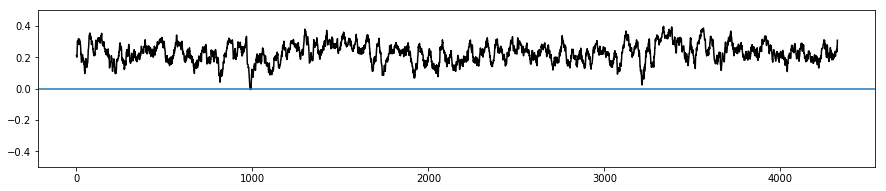

In [66]:
#window = 25
#bc5_smooth = smooth_list(y,window)

fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(luc_score_running, color="k")

#t =  plt.title('Smoothed Distribution of Tesserae Matches for Elegists ~ Lucan Book 5',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)

#ax.set_xlabel('Line Number', fontsize = 14)
#ax.set_ylabel('Count of Matches >=6', fontsize = 14)
plt.show()

In [67]:
boethius = preprocess("""carmina qui quondam studio florente peregi, 
     flebilis heu maestos cogor inire modos. 
ecce mihi lacerae dictant scribenda Camenae 
     et ueris elegi fletibus ora rigant. 
5has saltem nullus potuit peruincere terror, 
     ne nostrum comites prosequerentur iter. 
gloria felicis olim uiridisque iuuentae, 
     solantur maesti nunc mea fata senis. 
uenit enim properata malis inopina senectus 
10      et dolor aetatem iussit inesse suam. 
intempestiui funduntur uertice cani 
     et tremit effeto corpore laxa cutis. 
mors hominum felix, quae se nec dulcibus annis 
     inserit et maestis saepe uocata uenit. 
15eheu, quam surda miseros auertitur aure 
     et flentes oculos claudere saeua negat! 
dum leuibus male fida bonis fortuna faueret 
     paene caput tristis merserat hora meum; 
nunc quia fallacem mutauit nubila uultum 
20      protrahit ingratas impia uita moras. 
quid me felicem totiens iactastis, amici? 
     qui cecidit, stabili non erat ille gradu. 
     haec dum me cum tacitus ipse reputarem querimoniamque lacrimabilem stili officio signarem astitisse mihi supra uerticem uisa est mulier reuerendi admodum uultus, oculis ardentibus et ultra commumem hominum ualentiam perspicacibus, colore uiuido atque inexhausti uigoris, quamuis ita aeui plena foret ut nullo modo nostrae crederetur aetatis, statura discretionis ambiguae. nam nunc quidem ad communem sese hominum mensuram cohibebat,nunc uero pulsare caelum summi uerticis cacumine uidebatur; quae cum altius caput extulisset ipsum etiam caelum penetrabat respicientiumque hominum frustrabatur intuitum. uestes erant tenuissimis filis subtili artificio indissolubili materia perfectae, quas, uti post eadem prodente cognoui, suis manibus ipsa texuerat; quarum speciem, ueluti fumosas imagines solet, caligo quaedam neglectae uetustatis obduxerat. harum in extremo margine Π graecum, in supremo uero Θ legebatur intextum atque inter utrasque litteras in scalarum modum gradus quidam insigniti uidebantur, quibus ab inferiore ad superius elementum esset ascensus. eandem tamen uestem uiolentorum quorundam sciderant manus et particulas quas quisque potuit abstulerant. et dextra quidem eius libellos, sceptrum uero sinistra gestabat.
quae ubi poeticas Musas uidit nostro assistentes toro fletibusque meis uerba dictantes, commota paulisper ac toruis inflammata luminibus: quis, inquit, has scenicas meretriculas ad hunc aegrum permisit accedere, quae dolores eius non modo nullis remediis fouerent, uerum dulcibus insuper alerent uenenis? hae sunt enim quae infructuosis affectuum spinis uberem fructibus rationis segetem necant hominumque mentes assuefaciunt morbo, non liberant. at si quem profanum, uti uulgo solitum uobis, blanditiae uestrae detraherent, minus moleste ferendum putarem -- nihil quippe in eo nostrae operae laederentur -- hunc uero Eleaticis atque Academicis studiis innutritum? sed abite potius, Sirenes usque in exitium dulces, meisque eum Musis curandum sanandumque relinquite. his ille chorus increpitus deiecit humi maestior uultum confessusque rubore uerecundiam limen tristis excessit. at ego, cuius acies lacrimis mersa caligaret nec dinoscere possem quaenam haec esset mulier tam imperiosae auctoritatis, obstupui uisuque in terram defixo quidnam deinceps esset actura exspectare tacitus coepi. tum illa propius accedens in extrema lectuli mei parte consedit meumque intuens uultum luctu grauem atque in humum maerore deiectum his uersibus de nostrae mentis perturbatione conquesta est:
heu, quam praecipiti mersa profundo 
mens hebet et propria luce relicta 
tendit in externas ire tenebras 
terrenis quotiens flatibus aucta 
5crescit in immensum noxia cura! 
hic quondam caelo liber aperto 
suetus in aetherios ire meatus 
cernebat rosei lumina solis, 
uisebat gelidae sidera lunae 
10et quaecumque uagos stella recursus 
exercet uarios flexa per orbes 
comprensam numeris uictor habebat; 
quin etiam causas unde sonora 
flamina sollicitent aequora ponti, 
15quis uolat stabilem spiritus orbem 
uel cur hesperias sidus in undas 
casurum rutilo surgat ab ortu, 
quid ueris placidas temperet horas 
ut terram roseis floribus ornet, 
20quis dedit ut pleno fertilis anno 
autumnus grauidis influat uuis 
rimari solitus atque latentis 
naturae uarias reddere causas: 
nunc iacet effeto lumine mentis 
25et pressus grauibus colla catenis 
decliuem que gerens pondere uultum 
cogitur, heu, stolidam cernere terram.
sed medicinae, inquit, tempus est quam querelae. tum uero totis in me intenta luminibus: tune ille es, ait, qui nostro quondam lacte nutritus, nostris educatus alimentis in uirilis animi robur euaseras? atqui talia contuleramus arma quae nisi prior abiecisses inuicta te firmitate tuerentur. agnoscisne me? quid taces? pudore an stupore siluisti? mallem pudore, sed te, ut uideo, stupor oppressit. cumque me non modo tacitum sed elinguem prorsus mutumque uidisset, ammouit pectori meo leniter manum et: nihil, inquit, pericli est, lethargum patitur, communem illusarum mentium morbum. sui paulisper oblitus est. recordabitur facile, si quidem nos ante cognouerit; quod ut possit, paulisper lumina eius mortalium rerum nube caligantia tergamus. haec dixit oculosque meos fletibus undantes contracta in rugam ueste siccauit.
tunc me discussa liquerunt nocte tenebrae 
     luminibusque prior rediit uigor, 
ut cum praecipiti glomerantur sidera Coro 
     nimbosisque polus stetit imbribus 
5sol latet ac nondum caelo uenientibus astris 
     desuper in terram nox funditur; 
hanc si Threicio Boreas emissus ab antro 
     uerberet et clausum reseret diem 
emicat et subito uibratus lumine Phoebus 
10      mirantes oculos radiis ferit. 
haud aliter tristitiae nebulis dissolutis hausi caelum et ad cognoscendam medicantis faciem mentem recepi. itaque ubi in eam deduxi oculos intuitumque defixi, respicio nutricem meam, cuius ab adulescentia laribus obuersatus fueram, Philosophiam. et quid, inquam, tu in has exsilii nostri solitudines, o omnium magistra uirtutum, supero cardine delapsa uenisti? an ut tu quoque me cum rea falsis criminationibus agiteris? -- an, inquit illa, te, alumne, desererem nec sarcinam quam mei nominis inuidia sustulisti communicato te cum labore partirer? atqui Philosophiae fas non erat incomitatum relinquere iter innocentis. meam scilicet criminationem uererer et quasi nouum aliquid accideret perhorrescerem? nunc enim primum censes apud improbos mores lacessitam periculis esse sapientiam? nonne apud ueteres quoque ante nostri Platonis aetatem magnum saepe certamen cum stultitiae temeritate certauimus eodemque superstite praeceptor eius Socrates iniustae uictoriam mortis me astante promeruit? cuius hereditatem cum deinceps Epicureum uulgus ac Stoicum ceterique pro sua quisque parte raptum ire molirentur meque reclamantem renitentemque uelut in partem praedae traherent, uestem quam meis texueram manibus disciderunt abreptisque ab ea panniculis totam me sibi cessisse credentes abiere. in quibus quoniam quaedam nostri habitus uestigia uidebantur, meos esse familiares imprudentia rata nonnullos eorum profanae multitudinis errore peruertit. quodsi nec Anaxagorae fugam nec Socratis uenenum nec Zenonis tormenta, quoniam sunt peregrina, nouisti, at Canios, at Senecas, at Soranos, quorum nec peruetusta nec incelebris memoria est, scire potuisti. quos nihil aliud in cladem detraxit nisi quod nostris moribus instituti studiis improborum dissimillimi uidebantur. itaque nihil est quod ammirere si in hoc uitae salo circumflantibus agitemur procellis, quibus hoc maxime propositum est, pessimis displicere. quorum quidem tametsi est numerosus exercitus spernendus tamen est, quoniam nullo duce regitur sed errore tantum temere ac passim lymphante raptatur. qui si quando contra nos aciem struens ualentior incubuerit, nostra quidem dux copias suas in arcem contrahit, illi uero circa diripiendas inutiles sarcinulas occupantur. at nos desuper irridemus uilissima rerum quaeque rapientes securi totius furiosi tumultus eoque uallo muniti quo grassanti stultitiae aspirare fas non sit.
""")
boethius_tokens = boethius.split()

In [68]:
boethius_breaks = []

for item in ['carmina', 'haec', 'praecipiti', 'medicinae', 'discussa', 'dissolutis']:
    boethius_breaks.append(boethius_tokens.index(item))

In [69]:
boethius_score = []

for token in boethius_tokens:
    if token in vocab:
        boethius_score.append(df2.loc[token][2]-.5)
    else:
        boethius_score.append(0)
        
boethius_score_running = running_mean(boethius_score, 25)

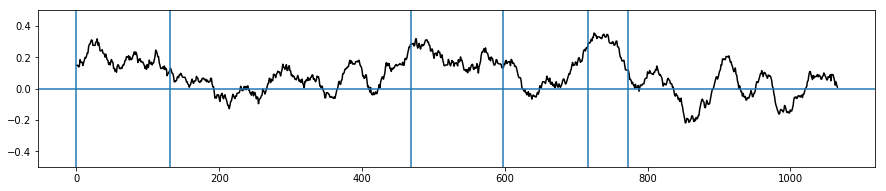

In [70]:
#window = 25
#bc5_smooth = smooth_list(y,window)

fig = plt.figure()
fig.set_size_inches(15,3)
ax = fig.add_subplot(111)
ax.plot(boethius_score_running, color="k")

#t =  plt.title('Smoothed Distribution of Tesserae Matches for Elegists ~ Lucan Book 5',fontsize = 18, fontweight = "bold")
#t.set_y(1.05)
fig.subplots_adjust(top=0.85)

ax.axhline(y=0)
for item in boethius_breaks:
    ax.axvline(x=item)

#ax.xaxis.labelpad = 10 
#ax.yaxis.labelpad = 10 

ax.set_ylim(-.5,.5)

#ax.set_xlabel('Line Number', fontsize = 14)
#ax.set_ylabel('Count of Matches >=6', fontsize = 14)
plt.show()